# –û–±—É—á–µ–Ω–∏–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ñ–µ–π–∫–æ–≤—ã—Ö —Ñ–∞–∫—Ç–æ–≤ –æ COVID –∏ –≤–∞–∫—Ü–∏–Ω–∞—Ü–∏–∏

In [53]:
import math

import torch
import pandas as pd
import numpy as np

In [54]:
DEVICE = 'cpu'
if torch.backends.mps.is_available():
    DEVICE = 'mps'
if torch.cuda.is_available():
    DEVICE = 'cuda'

In [55]:
from pathlib import Path

DATA_PATH = Path('data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_CACHE = Path('data/cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = Path('data/models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_colwidth', 500) 

In [56]:
MODEL_NAME = "roberta-base"
TRAIN_DF_NAME = "covid_vaccine_fake_clear.xlsx"
MAX_LENGTH = 128
BATCH_SIZE = 128

# –î–∞—Ç–∞—Å–µ—Ç

In [57]:
data_df = pd.read_excel(DATA_PATH / TRAIN_DF_NAME)
data_df.head(1)

text  \
0  The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.   

   label_idx original_label_1     source original_label_2 label_str  
0          0             real  nanyy1025              NaN      Real

## –í–∞–∂–Ω–æ, —É—Ä–µ–∑–∞–µ–º –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –µ—Å–ª–∏ —ç—Ç–æ –Ω—É–∂–Ω–æ

In [58]:
import pandas as pd

def balance_label_idx(data_df: pd.DataFrame, target_label: int = 2, target_count: int = 30000, random_state: int = 42) -> pd.DataFrame:
    """
    –û—Å—Ç–∞–≤–ª—è–µ—Ç –≤—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ label_idx, –Ω–æ —É–º–µ–Ω—å—à–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ target_label –¥–æ target_count —Å–ª—É—á–∞–π–Ω—ã–º –æ–±—Ä–∞–∑–æ–º.
    –í—Å–µ–≥–¥–∞ —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ source == 'handle_marked'.
    
    :param data_df: –ò—Å—Ö–æ–¥–Ω—ã–π DataFrame.
    :param target_label: –ó–Ω–∞—á–µ–Ω–∏–µ label_idx, –∫–æ—Ç–æ—Ä–æ–µ –Ω—É–∂–Ω–æ —É–º–µ–Ω—å—à–∏—Ç—å (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 2).
    :param target_count: –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫, –∫–æ—Ç–æ—Ä–æ–µ –Ω—É–∂–Ω–æ –æ—Å—Ç–∞–≤–∏—Ç—å –¥–ª—è target_label (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 30 000).
    :param random_state: –§–∏–∫—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ –≤—ã–±–æ—Ä–∫–∏.
    :return: –û–±–Ω–æ–≤–ª–µ–Ω–Ω—ã–π DataFrame.
    """
    # –û—Ç–¥–µ–ª—å–Ω–æ –≤—ã–¥–µ–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ source == 'handle_marked' (–∏—Ö –Ω–µ –±–∞–ª–∞–Ω—Å–∏—Ä—É–µ–º)
    df_handle_marked = data_df[data_df["source"] == "handle_marked"]
    
    # –ò—Å–∫–ª—é—á–∞–µ–º —ç—Ç–∏ —Å—Ç—Ä–æ–∫–∏ –∏–∑ –¥–∞–ª—å–Ω–µ–π—à–µ–π –æ–±—Ä–∞–±–æ—Ç–∫–∏
    data_df = data_df[data_df["source"] != "handle_marked"]

    # –û—Å—Ç–∞–≤–ª—è–µ–º –≤—Å–µ —Å—Ç—Ä–æ–∫–∏, –∫—Ä–æ–º–µ —Ç–µ—Ö, —É –∫–æ—Ç–æ—Ä—ã—Ö label_idx == target_label
    df_other_labels = data_df[data_df["label_idx"] != target_label]
    
    # –í—ã–±–∏—Ä–∞–µ–º —Å–ª—É—á–∞–π–Ω—ã–µ target_count —Å—Ç—Ä–æ–∫, –≥–¥–µ label_idx == target_label
    df_target_label = data_df[data_df["label_idx"] == target_label].sample(
        n=min(target_count, len(data_df[data_df["label_idx"] == target_label])), 
        random_state=random_state
    )
    
    # –û–±—ä–µ–¥–∏–Ω—è–µ–º –æ–±—Ä–∞—Ç–Ω–æ –∏ –¥–æ–±–∞–≤–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏ —Å source == 'handle_marked'
    balanced_df = pd.concat([df_other_labels, df_target_label, df_handle_marked])

    # –ü–µ—Ä–µ–º–µ—à–∏–≤–∞–µ–º —Å—Ç—Ä–æ–∫–∏ –∏ —Å–±—Ä–∞—Å—ã–≤–∞–µ–º –∏–Ω–¥–µ–∫—Å—ã
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df

data_df = balance_label_idx(data_df, target_count=100000)

In [59]:
data_df = data_df.fillna("")

for col in data_df.select_dtypes(include=["object", "bool"]).columns:
    data_df[col] = data_df[col].astype(str)

In [60]:
idx2label = {
    0: "Real",
    1: "Fake",
    2: "Comments"
}

In [61]:
NUM_CLASSES = len(idx2label)
NUM_CLASSES

3

In [62]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df["label_idx"], random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["label_idx"], random_state=42, shuffle=True)

print(f"–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(train_df)}")
print(f"–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(val_df)}")
print(f"–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(test_df)}")

–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 94179
–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 10465
–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 11628


In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd
from typing import Dict, Tuple


class TokenizedDataset(Dataset):
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        tokenizer: PreTrainedTokenizer, 
        max_length: int, 
        tensor_dtype: Tuple[torch.dtype, torch.dtype, torch.dtype] = (torch.long, torch.long, torch.long)
    ):
        """
        –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞—Ç–∞—Å–µ—Ç–∞ —Å —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–µ–π.

        Args:
            dataframe (pd.DataFrame): DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ "text" –∏ "label".
            tokenizer (PreTrainedTokenizer): –¢–æ–∫–µ–Ω–∞–π–∑–µ—Ä –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è —Ç–µ–∫—Å—Ç–∞.
            max_length (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ç–æ–∫–µ–Ω–æ–≤.
            tensor_dtype (tuple): –¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ç–æ–∫–µ–Ω–æ–≤ –∏ –º–µ—Ç–æ–∫.
        """
        self.tensor_dtype = tensor_dtype

        # –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö
        tokenized_data = tokenizer(
            dataframe["text"].tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        self.input_ids = tokenized_data["input_ids"].to(dtype=self.tensor_dtype[0])
        self.attention_mask = tokenized_data["attention_mask"].to(dtype=self.tensor_dtype[1])
        self.labels = torch.tensor(dataframe["label_idx"].tolist(), dtype=self.tensor_dtype[2])

    def __len__(self) -> int:
        """
        –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–º–µ—Ä–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ.
        """
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –∏ –º–µ—Ç–∫–∏.

        Args:
            idx (int): –ò–Ω–¥–µ–∫—Å –ø—Ä–∏–º–µ—Ä–∞.

        Returns:
            Dict[str, torch.Tensor]: –°–ª–æ–≤–∞—Ä—å —Å —Ç–æ–∫–µ–Ω–∞–º–∏ –∏ –º–µ—Ç–∫–æ–π.
        """
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


In [64]:
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd


def create_dataloader(
    dataframe: pd.DataFrame,
    tokenizer: PreTrainedTokenizer,
    max_length: int = 64,
    batch_size: int = 16,
    shuffle: bool = True,
    tensor_dtype=(torch.long, torch.long, torch.long),
) -> DataLoader:
    """
    –°–æ–∑–¥–∞–Ω–∏–µ DataLoader –∏–∑ DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ "text" –∏ "label".
        tokenizer (PreTrainedTokenizer): –¢–æ–∫–µ–Ω–∞–π–∑–µ—Ä –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è —Ç–µ–∫—Å—Ç–∞.
        max_length (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ç–æ–∫–µ–Ω–æ–≤.
        batch_size (int): –†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞.
        shuffle (bool): –ü–µ—Ä–µ–º–µ—à–∏–≤–∞—Ç—å –ª–∏ –¥–∞–Ω–Ω—ã–µ.
        tensor_dtype (tuple): –¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ç–æ–∫–µ–Ω–æ–≤ –∏ –º–µ—Ç–æ–∫.

    Returns:
        DataLoader: DataLoader –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å –º–æ–¥–µ–ª—å—é.
    """
    dataset = TokenizedDataset(dataframe, tokenizer, max_length, tensor_dtype=tensor_dtype)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
    )
    return dataloader


In [65]:
from transformers import RobertaTokenizer

tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, cache_dir=DATA_CACHE)

train_loader = create_dataloader(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = create_dataloader(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = create_dataloader(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# –í—ã–≤–æ–¥–∏–º —Ä–∞–∑–º–µ—Ä –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö
print(f"–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(train_loader.dataset)}")
print(f"–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(val_loader.dataset)}")
print(f"–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞: {len(test_loader.dataset)}")


–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 94179
–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 10465
–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞: 11628


# –ú–æ–¥–µ–ª—å

In [66]:
from typing import Tuple, Dict, Any

import torch
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


class VaccineFakeClassifierTrainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        criterion: torch.nn.Module,
        device: torch.device,
    ):
        """
        –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª–∞—Å—Å–∞ Trainer.

        Args:
            model: –ú–æ–¥–µ–ª—å –¥–ª—è –æ–±—É—á–µ–Ω–∏—è (e.g., RobertaForSequenceClassification).
            train_loader: DataLoader –¥–ª—è –æ–±—É—á–∞—é—â–µ–≥–æ –Ω–∞–±–æ—Ä–∞.
            val_loader: DataLoader –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –Ω–∞–±–æ—Ä–∞.
            optimizer: –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä.
            criterion: –§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å.
            device: –£—Å—Ç—Ä–æ–π—Å—Ç–≤–æ ('cuda' –∏–ª–∏ 'cpu').
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_metrics": [],
            "val_metrics": []
        }

        self.model.to(self.device)

    def train_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∑–∞ –æ–¥–Ω—É —ç–ø–æ—Ö—É.

        Returns:
            –°—Ä–µ–¥–Ω–∏–µ –ø–æ—Ç–µ—Ä–∏ –∏ –º–µ—Ç—Ä–∏–∫–∏ –∑–∞ —ç–ø–æ—Ö—É.
        """
        self.model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for batch in tqdm(self.train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            running_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.train_loader)
        return epoch_loss, metrics

    def validate_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        –í–∞–ª–∏–¥–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∑–∞ –æ–¥–Ω—É —ç–ø–æ—Ö—É.

        Returns:
            –°—Ä–µ–¥–Ω–∏–µ –ø–æ—Ç–µ—Ä–∏ –∏ –º–µ—Ç—Ä–∏–∫–∏ –∑–∞ —ç–ø–æ—Ö—É.
        """
        self.model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                running_loss += loss.item()

                preds = logits.argmax(dim=-1)
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.val_loader)
        return epoch_loss, metrics

    def fit(self, num_epochs: int):
        """
        –û–±—É—á–µ–Ω–∏–µ –∏ –≤–∞–ª–∏–¥–∞—Ü–∏—è –º–æ–¥–µ–ª–∏.

        Args:
            num_epochs: –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö.
        """
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate_epoch()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_metrics"].append(train_metrics)
            self.history["val_metrics"].append(val_metrics)

            print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
            print(f"Train Metrics: {train_metrics} | Validation Metrics: {val_metrics}")

    def plot_results(self, metrics_to_plot=None):
        """
        –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–æ–≤ –ø–æ—Ç–µ—Ä—å –∏ –º–µ—Ç—Ä–∏–∫ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–∏.

        Args:
            metrics_to_plot: –°–ø–∏—Å–æ–∫ –º–µ—Ç—Ä–∏–∫ –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1"]

        num_plots = len(metrics_to_plot) + 1
        plt.figure(figsize=(15, 5 * (num_plots // 2 + 1)))

        # –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
        plt.subplot((num_plots + 1) // 2, 2, 1)
        plt.plot(self.history["train_loss"], label="Train Loss", color="blue", linestyle="--")
        plt.plot(self.history["val_loss"], label="Validation Loss", color="red", linestyle="-")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)

        # –ì—Ä–∞—Ñ–∏–∫–∏ –º–µ—Ç—Ä–∏–∫
        for i, metric in enumerate(metrics_to_plot, start=2):
            train_metric = [m[metric] for m in self.history["train_metrics"]]
            val_metric = [m[metric] for m in self.history["val_metrics"]]

            plt.subplot((num_plots + 1) // 2, 2, i)
            plt.plot(train_metric, label=f"Train {metric.capitalize()}", color="blue", linestyle="--")
            plt.plot(val_metric, label=f"Validation {metric.capitalize()}", color="red", linestyle="-")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.title(f"{metric.capitalize()} over Epochs")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _compute_metrics(preds: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
        """
        –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫.

        Args:
            preds: –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–æ–¥–µ–ª–∏.
            labels: –ò—Å—Ç–∏–Ω–Ω—ã–µ –º–µ—Ç–∫–∏.

        Returns:
            –°–ª–æ–≤–∞—Ä—å –º–µ—Ç—Ä–∏–∫.
        """
        preds = preds.numpy()
        labels = labels.numpy()

        metrics = {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted"),
        }
        return metrics

# –û–±—É—á–µ–Ω–∏–µ

In [67]:
import torch
from torch.optim import AdamW
from transformers import RobertaForSequenceClassification

LEARNING_RATE = 1e-5
NUM_EPOCHS = 2
WEIGHT_DECAY = 0.01

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_CLASSES, cache_dir=DATA_CACHE)

model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
from torch.optim import Adagrad, RMSprop

# optimizer = Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# optimizer = RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, alpha=0.9, momentum=0.9)

In [69]:
trainer = VaccineFakeClassifierTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
)

In [70]:
trainer.fit(num_epochs=NUM_EPOCHS)


Epoch 1/2


Training:   0%|          | 0/736 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.0804 | Validation Loss: 0.0407
Train Metrics: {'accuracy': 0.9727327748224126, 'f1': 0.9718870047676407} | Validation Metrics: {'accuracy': 0.9873865265169613, 'f1': 0.9873166012607029}

Epoch 2/2


Training:   0%|          | 0/736 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.0290 | Validation Loss: 0.0311
Train Metrics: {'accuracy': 0.9898278809501057, 'f1': 0.9897844929497372} | Validation Metrics: {'accuracy': 0.9894887720974678, 'f1': 0.9894652538757746}


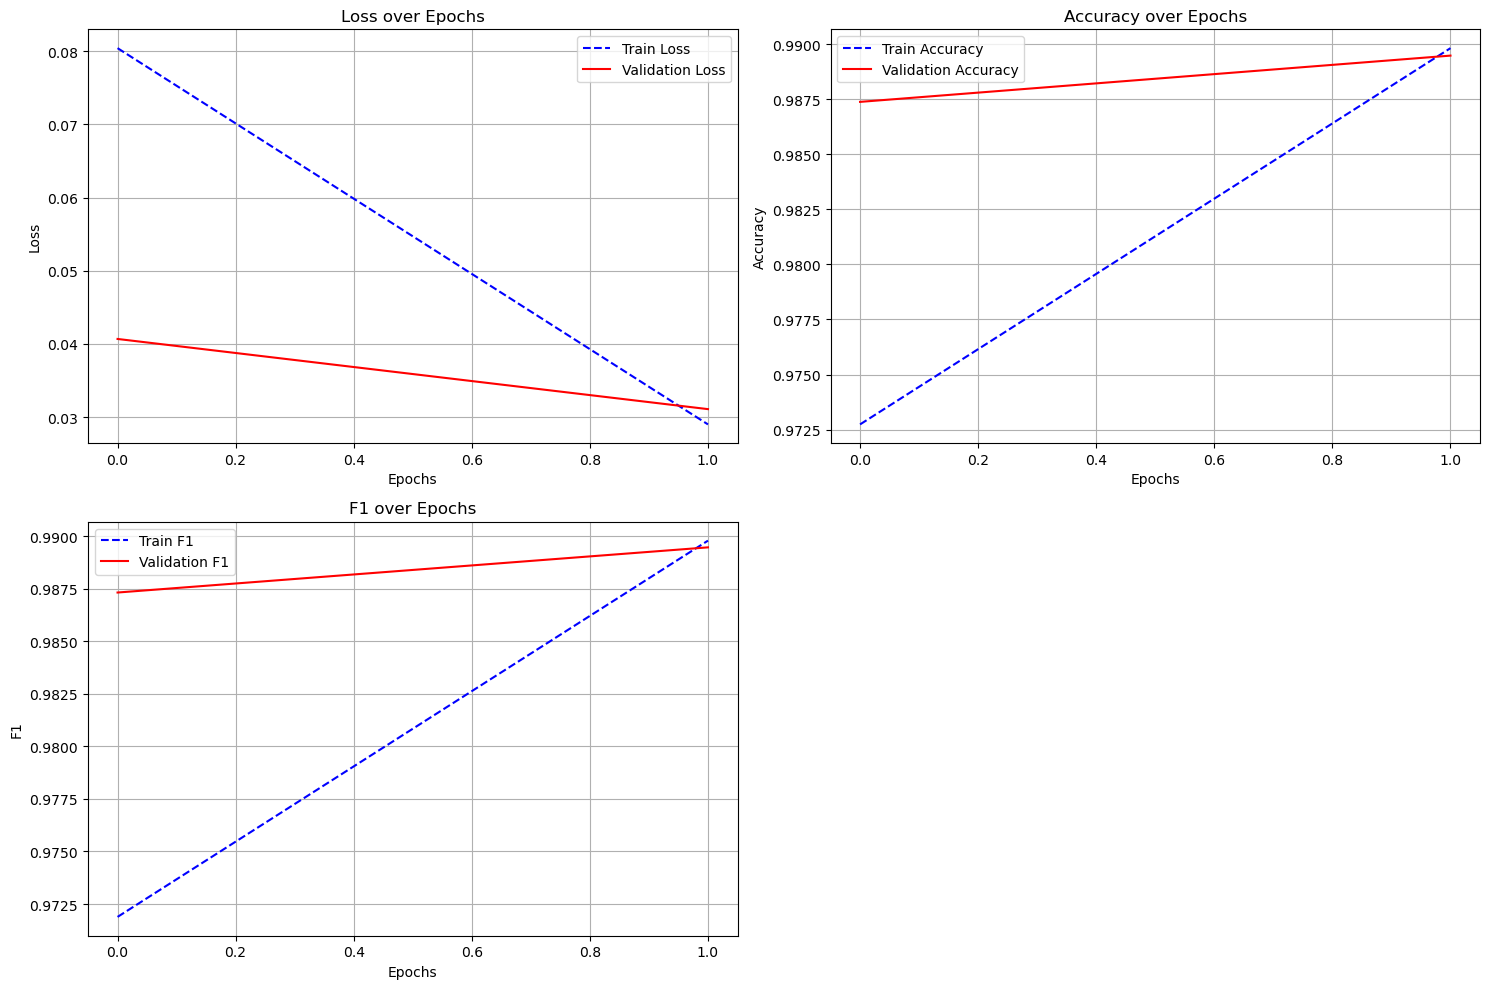

In [71]:
trainer.plot_results()

In [72]:
model_save_path = DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"–ú–æ–¥–µ–ª—å –∏ —Ç–æ–∫–∏–Ω–∞–π–∑–µ—Ä —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {model_save_path}")

–ú–æ–¥–µ–ª—å –∏ —Ç–æ–∫–∏–Ω–∞–π–∑–µ—Ä —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: data\models\covid_vaccine_fake_model


## –≠–Ω—Ç—Ä–æ–ø–∏—è (—É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏)

In [73]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
from torch.utils.data import DataLoader
from typing import Dict, Any


def compute_entropy_thresholds(model: torch.nn.Module, dataloader: DataLoader, device: torch.device) -> Dict[str, Any]:
    """
    –í—ã—á–∏—Å–ª—è–µ—Ç —ç–Ω—Ç—Ä–æ–ø–∏—é –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –º–æ–¥–µ–ª–∏ –¥–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –∏ –Ω–∞—Ö–æ–¥–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –ø–æ—Ä–æ–≥–∏.
    
    Args:
        model (torch.nn.Module): –û–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏.
        dataloader (DataLoader): –í–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç.
        device (torch.device): CUDA –∏–ª–∏ CPU.

    Returns:
        Dict[str, Any]: –°–æ–¥–µ—Ä–∂–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –ø–æ—Ä–æ–≥–∏ —ç–Ω—Ç—Ä–æ–ø–∏–∏, ROC AUC –∏ DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏.
    """
    model.to(device)
    model.eval()

    # –°–ª–æ–≤–∞—Ä–∏ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —ç–Ω—Ç—Ä–æ–ø–∏–∏ –∏ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
    entropies_per_class = defaultdict(list)
    correct_per_class = defaultdict(list)

    # –°–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = F.softmax(outputs.logits, dim=1)

            # –≠–Ω—Ç—Ä–æ–ø–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-15), dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            correct = (predicted_labels == labels).float()

            # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –∫–ª–∞—Å—Å–∞–º
            for i in range(len(labels)):
                label = labels[i].item()
                entropies_per_class[label].append(entropy[i].item())
                correct_per_class[label].append(correct[i].item())

    # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞ —ç–Ω—Ç—Ä–æ–ø–∏–∏
    optimal_thresholds = {}
    roc_aucs = {}
    all_entropies = []
    all_correct = []
    results = []

    plt.figure(figsize=(12, 8))

    for label, entropies in entropies_per_class.items():
        correct = np.array(correct_per_class[label])
        entropies = np.array(entropies)

        if len(np.unique(correct)) < 2:
            optimal_thresholds[label] = None
            roc_aucs[label] = None
            results.append({'label': label, 'AUC': None, 'optimal_threshold': None})
            continue

        # ROC –∏ AUC
        fpr, tpr, thresholds = roc_curve(correct, -entropies)
        roc_auc = roc_auc_score(correct, -entropies)

        # –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = -thresholds[optimal_idx]

        optimal_thresholds[label] = optimal_threshold
        roc_aucs[label] = roc_auc

        all_entropies.extend(entropies)
        all_correct.extend(correct)

        # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
        results.append({'label': label, 'AUC': roc_auc, 'optimal_threshold': optimal_threshold})

        # –î–æ–±–∞–≤–ª—è–µ–º –∫—Ä–∏–≤—É—é –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
        plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.4f})')
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red')

    # –û–±—â–∏–π –ø–æ—Ä–æ–≥ —ç–Ω—Ç—Ä–æ–ø–∏–∏
    all_entropies = np.array(all_entropies)
    all_correct = np.array(all_correct)
    fpr, tpr, thresholds = roc_curve(all_correct, -all_entropies)
    roc_auc = roc_auc_score(all_correct, -all_entropies)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    overall_optimal_threshold = -thresholds[optimal_idx]

    print(f"–û–±—â–∏–π –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ —ç–Ω—Ç—Ä–æ–ø–∏–∏: {overall_optimal_threshold:.4f}")
    print(f"AUC ROC (–æ–±—â–∏–π): {roc_auc:.4f}")

    # –î–æ–±–∞–≤–ª—è–µ–º –æ–±—â—É—é ROC-–∫—Ä–∏–≤—É—é
    plt.plot(fpr, tpr, label=f'Overall (AUC = {roc_auc:.4f})', linestyle='--', color='black')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='blue', label='Overall Optimal')

    # –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class and Overall')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # –°–æ–∑–¥–∞–Ω–∏–µ DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)

    return {
        'overall_optimal_threshold': overall_optimal_threshold,
        'optimal_thresholds': optimal_thresholds,
        'roc_aucs': roc_aucs,
        'results_df': results_df
    }


–û–±—â–∏–π –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ —ç–Ω—Ç—Ä–æ–ø–∏–∏: 0.0656
AUC ROC (–æ–±—â–∏–π): 0.9784


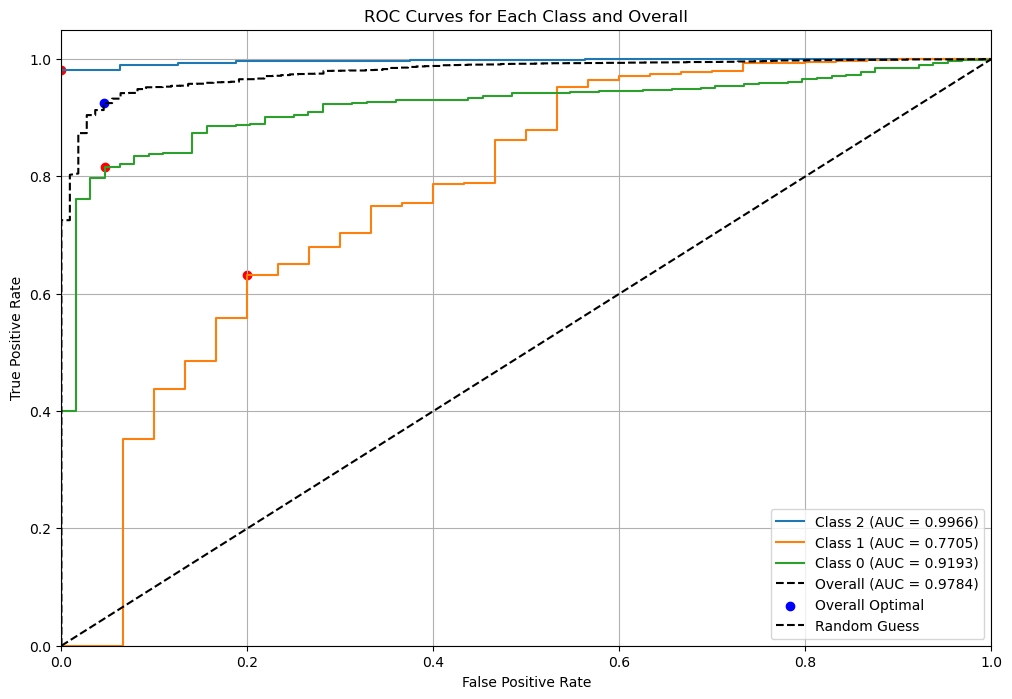

   label       AUC  optimal_threshold
0      2  0.996633           0.048492
1      1  0.770476           0.119393
2      0  0.919256           0.122038


In [74]:
entropy_dict = compute_entropy_thresholds(model, val_loader, DEVICE)

print(entropy_dict["results_df"])


In [75]:
entropy_dict["optimal_thresholds"]

{2: 0.048492107540369034, 1: 0.1193934753537178, 0: 0.12203813344240189}

# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ

In [87]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
from typing import Dict


def test_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    test_df: pd.DataFrame,
    idx2label: Dict[int, str],
    entropy_thresholds: Dict[int, float],  # –ü–æ—Ä–æ–≥–∏ —ç–Ω—Ç—Ä–æ–ø–∏–∏ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> pd.DataFrame:
    """
    –¢–µ—Å—Ç–∏—Ä—É–µ—Ç –º–æ–¥–µ–ª—å –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º DataLoader –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏.

    Args:
        model (torch.nn.Module): –û–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å.
        test_loader (DataLoader): DataLoader –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞.
        test_df (pd.DataFrame): –ò—Å—Ö–æ–¥–Ω—ã–π DataFrame —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö.
        idx2label (dict): –°–ª–æ–≤–∞—Ä—å, –æ—Ç–æ–±—Ä–∞–∂–∞—é—â–∏–π –∏–Ω–¥–µ–∫—Å—ã –∫–∞—Ç–µ–≥–æ—Ä–∏–π –≤ –Ω–∞–∑–≤–∞–Ω–∏—è.
        entropy_thresholds (dict): –û–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –ø–æ—Ä–æ–≥–∏ —ç–Ω—Ç—Ä–æ–ø–∏–∏ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º.
        device (torch.device): –£—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –¥–ª—è –≤—ã—á–∏—Å–ª–µ–Ω–∏–π (CPU/GPU).

    Returns:
        pd.DataFrame: DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏, —Å–æ–¥–µ—Ä–∂–∞—â–∏–π:
            - 'text': —Ç–µ–∫—Å—Ç –ø—Ä–∏–º–µ—Ä–∞,
            - 'true_label': –∏—Å—Ç–∏–Ω–Ω–∞—è –º–µ—Ç–∫–∞,
            - 'predicted_label': –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è –º–µ—Ç–∫–∞,
            - 'probability': –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è,
            - 'correct': –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è (True/False),
            - 'entropy': —ç–Ω—Ç—Ä–æ–ø–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è,
            - 'entropy_threshold': –ø–æ—Ä–æ–≥ —ç–Ω—Ç—Ä–æ–ø–∏–∏ –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∏,
            - 'passed_threshold': –ø—Ä–æ—à–ª–æ –ª–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –ø–æ—Ä–æ–≥ —ç–Ω—Ç—Ä–æ–ø–∏–∏.
    """
    model.eval()
    model.to(device)

    test_results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probabilities = torch.softmax(logits, dim=-1)

            # –≠–Ω—Ç—Ä–æ–ø–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-15), dim=1)

            predictions = torch.argmax(probabilities, dim=-1).cpu().numpy()
            true_labels = true_labels.cpu().numpy()
            entropies = entropy.cpu().numpy()
            probabilities = probabilities.cpu().numpy()

            for true_label, predicted_label, probs, entropy_value in zip(true_labels, predictions, probabilities, entropies):
                entropy_threshold = entropy_thresholds.get(predicted_label, None)
                passed_threshold = entropy_value < entropy_threshold if entropy_threshold is not None else None

                test_results.append({
                    "true_label": idx2label[true_label],
                    "predicted_label": idx2label[predicted_label],
                    "probability": probs.tolist(),
                    "correct": true_label == predicted_label,
                    "entropy": entropy_value,
                    "entropy_threshold": entropy_threshold,
                    "passed_threshold": passed_threshold,
                })

    test_results_df = pd.DataFrame(test_results)

    test_df = test_df.reset_index(drop=True)
    test_df = pd.concat([test_df, test_results_df], axis=1)

    accuracy = accuracy_score(test_df["true_label"], test_df["predicted_label"])
    f1 = f1_score(test_df["true_label"], test_df["predicted_label"], average="weighted")

    print("\n=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    return test_df


In [88]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")
model = RobertaForSequenceClassification.from_pretrained(
    DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")

model.to(DEVICE)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [89]:
test_results_df = test_model(
    model=model,
    test_loader=test_loader,
    test_df=test_df,
    idx2label=idx2label,
    entropy_thresholds=entropy_dict["optimal_thresholds"],
    device=DEVICE,
)

Testing:   0%|          | 0/91 [00:00<?, ?it/s]


=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è ===
Accuracy: 98.91%
F1 Score: 0.9891


In [90]:
test_results_df.sample(10)

text  \
10911                                                                                                      I did it was really really hot and sunny, and am sad am back   
5402                                                                               So that's the trick  Really enjoy your posts, btw, remarkably varied and insightful!   
4791                                                                                                           Danny and then Tom closely followed  yours Danny? lol. x   
11139                                                                                                        Oh yea, join the club I'm feeling wasted myself!! Luv it!!   
2959                                                                                                                                              aww my little darling   
2268                                                                                            hopefully. Least my party of choice isn't in bed with homophobes, dear.   
9046   dictatorial threats mean nothing ive violated policy banned wiki privilege site going obsolete like run biased heap website ability fair might saved seem likely   
4047                                                                                                                           thanks already saw knew coming hasspoken   
8606                                                                                                           lmao i am soo proud of my eye makeup..i almost cried  XD   
9058                                                                                                       we're both good  how's you &amp; the gorgeous little Hunter?   

       label_idx original_label_1          source original_label_2 label_str  \
10911          2            False         twitter                   Comments   
5402           2             True         twitter                   Comments   
4791           2             True         twitter                   Comments   
11139          2             True         twitter                   Comments   
2959           2            False         twitter                   Comments   
2268           2             True         twitter                   Comments   
9046           2            False  toxic_comments                   Comments   
4047           2             True  toxic_comments                   Comments   
8606           2             True         twitter                   Comments   
9058           2             True         twitter                   Comments   

      true_label predicted_label  \
10911   Comments        Comments   
5402    Comments        Comments   
4791    Comments        Comments   
11139   Comments        Comments   
2959    Comments        Comments   
2268    Comments        Comments   
9046    Comments        Comments   
4047    Comments        Comments   
8606    Comments        Comments   
9058    Comments        Comments   

                                                               probability  \
10911    [0.00010105571709573269, 7.806330540915951e-05, 0.99982088804245]   
5402    [0.00012282172974664718, 9.709874575491995e-05, 0.999779999256134]   
4791    [0.00010315349936718121, 6.43838502583094e-05, 0.9998325109481812]   
11139     [7.1592592576053e-05, 6.320236570900306e-05, 0.9998651742935181]   
2959    [7.410299440380186e-05, 5.470388714456931e-05, 0.9998711347579956]   
2268   [0.0002791146980598569, 0.00027691334253177047, 0.9994439482688904]   
9046    [0.00010721065336838365, 9.524106280878186e-05, 0.999797523021698]   
4047      [8.7467284174636e-05, 6.210686842678115e-05, 0.9998503923416138]   
8606       [8.02158028818667e-05, 7.81325506977737e-05, 0.999841570854187]   
9058    [8.237719157477841e-05, 7.073820597724989e-05, 0.9998469352722168]   

       correct   entropy  entropy_threshold  passed_threshold  
10911     True  0.002665           0.048492              True  
5402      True  

In [100]:
import pandas as pd

pd.options.display.max_colwidth = 300


test_results_df.loc[
    (test_results_df["predicted_label"] == "Fake")
].sample(10)

text  \
5565                                                                                            COVID-19 vaccine poses risk when taken before and after periods   
8584                                                                             Cruise lines now offer deluxe coronavirus upgrade over basic norovirus package   
11112                                   the video shows the bodies of deceased COVID-19 victims washing ashore after some countries disposed of them in the sea   
11002                                                                                  CNN anchor decries controversial police unit, Covid-19 deaths in Nigeria   
8827         RETRACTED: Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis - The Lancet   
8573                                                                                                     Covaxin COVID-19 vaccine contains new born calf serum.   
2267                                                        The World Health Organization ‚Äúnow admits that asymptomatic transmission of COVID-19 is very rare.‚Äù   
11490                                                                                                            The Pfizer COVID-19 vaccine ‚Äúis not approved.‚Äù   
4740   ‚ÄúHundreds of thousands died after taking the advice of these celebrities,‚Äù who are ‚Äúaiding and abetting mass murder‚Äù by advocating COVID-19 vaccination.   
3635                                  Vaccines do not contain microchips or tracking devices. Such claims are misinformation and have been debunked by experts.   

       label_idx original_label_1        source original_label_2 label_str  \
5565           1            False  justinqbui_1                       Fake   
8584           1             fake     nanyy1025                       Fake   
11112          1            False  justinqbui_1                       Fake   
11002          1            False  justinqbui_1                       Fake   
8827           1             fake     nanyy1025                       Fake   
8573           1            False  justinqbui_1                       Fake   
2267           0        half-true  justinqbui_2       misleading      Real   
11490          1            false  justinqbui_2            false      Fake   
4740           1            False  justinqbui_1                       Fake   
3635           0                      synthetic                       Real   

      true_label predicted_label  \
5565        Fake            Fake   
8584        Fake            Fake   
11112       Fake            Fake   
11002       Fake            Fake   
8827        Fake            Fake   
8573        Fake            Fake   
2267        Real            Fake   
11490       Fake            Fake   
4740        Fake            Fake   
3635        Real            Fake   

                                                              probability  \
5565   [0.012371129356324673, 0.9874262809753418, 0.00020262060570530593]   
8584   [0.017445122823119164, 0.9823431372642517, 0.00021174702851567417]   
11112  [0.002578569808974862, 0.9970406889915466, 0.00038066162960603833]   
11002    [0.004942461382597685, 0.994819700717926, 0.0002379210345679894]   
8827      [0.2079472839832306, 0.791716456413269, 0.00033629449899308383]   
8573    [0.02407960221171379, 0.9756046533584595, 0.00031566989491693676]   
2267     [0.23730581998825073, 0.7622362375259399, 0.0004579645174089819]   
11490     [0.09700577706098557, 0.9018580913543701, 0.001136064063757658]   
4740     [0.14997027814388275, 0.8493533730506897, 0.0006763141718693078]   
3635   [0.0053765857592225075, 0.9940294027328491, 0.0005940102273598313]   

       correct   entropy  entropy_threshold  passed_threshold  
5565      True  0.098906           0.119393              True  
8584      True  0.129729           0.119393             False  
11112     True  0.030761           0.119393      

In [99]:
import pandas as pd

pd.options.display.max_colwidth = 300


test_results_df.loc[
    (test_results_df["predicted_label"] == "Real")
].sample(10)

text  \
471                                                   After running near 20% for most of April the cumulative positive rate has fallen a couple percent. All of these things are good signs even if we did add more than 27k positive cases to the rolls.   
107    Our daily update is published. We‚Äôve tracked a total of 1407271 completed tests up from 1267658 yesterday. That's a big jump the biggest yet: 140k. Note: we can only track what a state reports and not all states report all tests. For details:   
6456         Correctional facilities present unique challenges to slowing spread of  As of April 28 a total of 420 correctional facilities reported 4893 COVID-19 cases among detained or incarcerated people &amp; 2778 cases among facility staff. More   
8071                                                                                                 BREAKING: Sky News understands further  lockdown restrictions are set to be imposed in the North East of England. Sky's  has the latest üëá Read more:   
3862                                            Our daily update is published. States reported 769k tests 64k new cases and 523 deaths. Hospitalizations fell a little but there‚Äôs a major caveat there: The decline is due to strange data from Alabama.   
7048                                                                                                                                                                                         Test patients‚Äô vitamin D levels to improve immunoresponse to   
10296                                                                                                                                           Black children with COVID-19 at higher risk of developing the Kawasaki-like inflammatory condition MIS-C.   
5136                                                                                                                     Vaccines stimulate the production of memory cells in the immune system. These cells "remember" how to fight a specific pathogen.   
7244                                                                                                  COVID-19 vaccination programs include measures to monitor and report adverse events. This ensures rapid responses to any potential safety concerns.   
10      Pfizer‚Äôs announces that it will most likely know if their vaccine is effective by the end of October. If so Pfizer plans to begin distribution by 2021. The company is now looking to add more diverse and vulnerable populations to their trial.   

       label_idx original_label_1     source original_label_2 label_str  \
471            0             real  nanyy1025                       Real   
107            0             real  nanyy1025                       Real   
6456           0             real  nanyy1025                       Real   
8071           0             real  nanyy1025                       Real   
3862           0             real  nanyy1025                       Real   
7048           0             real  nanyy1025                       Real   
10296          0             real  nanyy1025                       Real   
5136           0                   synthetic                       Real   
7244           0                   synthetic                       Real   
10             0             real  nanyy1025                       Real   

      true_label predicted_label  \
471         Real            Real   
107         Real            Real   
6456        Real            Real   
8071        Real            Real   
3862        Real            Real   
7048        Real            Real   
10296       Real            Real   
5136        Real            Real   
7244        Real            Real   
10          Real            Real   

                                                               probability  \
471     [0.9972898960113525, 0.0022942693904042244, 0.0004158267693128437]   
107     [0.9979092478752136, 0.0016680139815434813, 0.00042266043601557

In [91]:
test_results_df.to_excel(DATA_PATH / 'test_results_learning.xlsx', index=False)

In [92]:
from transformers import PreTrainedTokenizer, PreTrainedModel
import torch


def test_model_with_text(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    text: str,
    max_length: int = 128,
    label_map: dict = None,
):
    """
    –ü—Ä–æ–≤–µ—Ä—è–µ—Ç –º–æ–¥–µ–ª—å –Ω–∞ –≤–≤–µ–¥–µ–Ω–Ω–æ–º –≤—Ä—É—á–Ω—É—é —Ç–µ–∫—Å—Ç–µ, –∏—Å–ø–æ–ª—å–∑—É—è argmax –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏.

    Args:
        model (PreTrainedModel): –ó–∞–≥—Ä—É–∂–µ–Ω–Ω–∞—è –æ–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (–Ω–∞–ø—Ä–∏–º–µ—Ä, RobertaForSequenceClassification).
        tokenizer (PreTrainedTokenizer): –¢–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä –¥–ª—è –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∏ —Ç–µ–∫—Å—Ç–∞.
        text (str): –¢–µ–∫—Å—Ç –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏.
        max_length (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞.
        label_map (dict): –°–ª–æ–≤–∞—Ä—å –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –º–µ—Ç–æ–∫, –µ—Å–ª–∏ –º–µ—Ç–∫–∏ —á–∏—Å–ª–æ–≤—ã–µ.

    Returns:
        dict: –°–ª–æ–≤–∞—Ä—å —Å —Ç–µ–∫—Å—Ç–æ–º, –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—è–º–∏ –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–º–∏ –º–µ—Ç–∫–∞–º–∏.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # –í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞

    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_label = label_map[predicted_index] if label_map else predicted_index

    # –†–µ–∑—É–ª—å—Ç–∞—Ç—ã
    result = {
        "text": text,
        "probabilities": probs.tolist(),
        "predicted_label": predicted_label
    }

    return result


Real

In [93]:
text = "COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research.', 'probabilities': [0.7534753084182739, 0.24608100950717926, 0.0004436891176737845], 'predicted_label': 'Real'}


Fake

In [94]:
text = "COVID-19 vaccines affect fertility or reproductive health."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines affect fertility or reproductive health.', 'probabilities': [0.21363011002540588, 0.7860375046730042, 0.00033243189682252705], 'predicted_label': 'Fake'}


In [95]:
text = "Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it‚Äôs way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I‚Äôm enjoying every moment as I feel my body reacting to the load. It‚Äôs definitely a great motivation to keep pushing forward! covid ruined everything though"

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

text = '''
The new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.
'''
result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it‚Äôs way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I‚Äôm enjoying every moment as I feel my body reacting to the load. It‚Äôs definitely a great motivation to keep pushing forward! covid ruined everything though', 'probabilities': [0.03248745575547218, 0.1955326795578003, 0.7719798684120178], 'predicted_label': 'Comments'}
{'text': '\nThe new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.\n', 'probabilities': [0.09138131886720657, 0.9084268808364868, 0.00019180566596332937], 'predicted_label': 'Fake'}
